In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pnd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import KFold
from itertools import product
from collections import Counter
import itertools
import inspect
from IPython.display import display, clear_output
from Utils import print_args

In [2]:
arr = np.genfromtxt('data/non-parametric.csv', delimiter=';')[1:,:]
xs, ys = arr[:,1:2].copy(), arr[:, 2:].ravel()

In [3]:
def shuffle(X, y):
    p = np.arange(0, X.shape[0])
    np.random.shuffle(p)
    return (X[p], y[p])
xs, ys = shuffle(xs, ys)

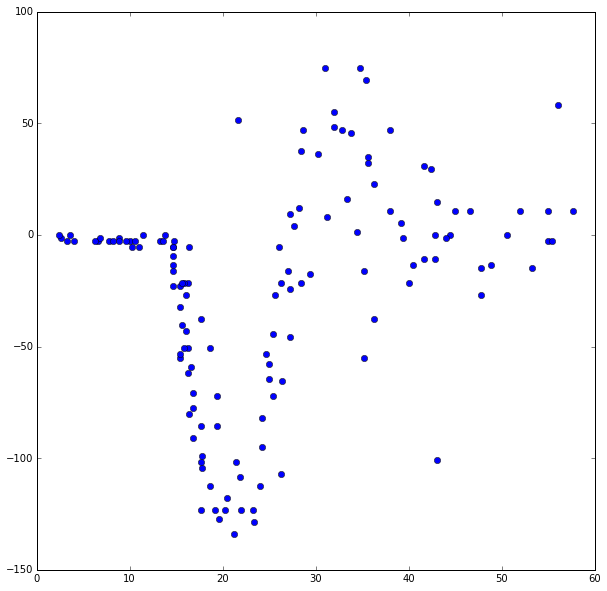

In [4]:
def show(xs, ys):
    plt.figure(figsize=(10, 10))
    label0, = plt.plot(xs, ys, 'bo')
    plt.show()
show(xs, ys)

/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


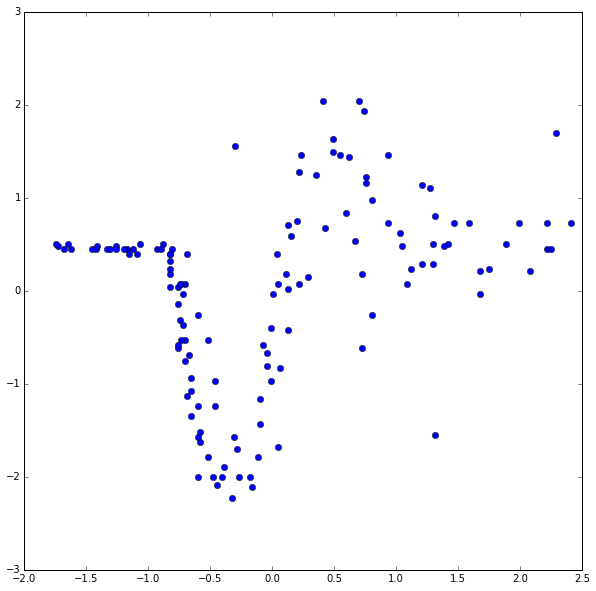

In [5]:
x_scaled = StandardScaler().fit_transform(xs)
y_scaled = StandardScaler().fit_transform(ys)
show(x_scaled, y_scaled)

In [10]:
def kf_cross_validation(regressor, xs, ys, measure, n_fold=10, times=1, verbose=False, **params):
    res = 0
    for _ in range(times):
        kf = KFold(len(xs), n_fold, True, 0)
        kf_sum = 0
        fold_num = 0
        for train_i, test_i in kf:
            regressor.fit(xs[train_i], ys[train_i], **params)
            predicted = np.apply_along_axis(regressor.predict, 1, xs[test_i])
            meas = measure(predicted, ys[test_i])
            fold_num += 1
            kf_sum += meas
            if verbose:
                print("Time {}, fold {} done, error = {}".format(_, fold_num, meas))
        res += kf_sum/n_fold
    if verbose:
        clear_output()
    return res/times

In [15]:
class NadarayaWatsonRegression:
    def fit(self, xs, ys, h, kernel='quad', metric='manh'):
        self.xs = xs
        self.ys = ys
        self.h = h
        if kernel == 'quad':
            self.kernel = lambda x: (15.0/16)*(1-x*x)**2 if (-1.0 <= x <= 1.0) else 0.0
        else:
            self.kernel = kernel
        if metric == 'manh':
            self.metric = lambda x, y: 1.0*abs(x-y).sum()
        else:
            self.metric = metric
        return self
            
    def predict(self, x):
        EPS = 1e-6
        K, po, h = self.kernel, self.metric, self.h
        kerneled = np.apply_along_axis(lambda xi: K(po(xi, x)/h), 1, self.xs)
        if kerneled.sum() < EPS:
            return 0
        return np.dot(kerneled, self.ys)/kerneled.sum()
measure = lambda x, y: ((x-y)**2).mean()
regressor = NadarayaWatsonRegression()

In [16]:
import time
class LOWESS:
    
    def predict(self, x, without=None):
        K, h, metric = self.K, self.h, self.metric
        kerneled = np.apply_along_axis(lambda xi: K(metric(xi,x)/h), 1, self.xs)
        if without is not None:
            kerneled[without] = 0
        kerneled = kerneled * self.gamma
        r = (np.dot(kerneled, self.ys)).sum()
        
        if kerneled.sum() < 1e-6:
            return 0
        return r / kerneled.sum()

    def f(self):
        return np.array([self.predict(self.xs[i, 0], i) for i in range(len(self.xs))])
        
    def fit(self, xs, ys, h, kernel='quad', metric='manh'):
        K1 = lambda x: (1-x**2)**2 if abs(x) <= 1 else 0
        self.gamma = np.ones(len(xs))
        self.h = h
        self.xs = xs
        self.ys = ys
        if kernel == 'quad':
            self.K = lambda x: (15.0/16)*(1-x**2)**2 if abs(x) <= 1 else 0.0
        else:
            self.K = kernel        
        if metric == 'manh':
            self.metric = lambda x, y: abs(x-y).sum()
        else:
            self.metric = metric
        it = 0
        while it < 10:
            a = np.array([self.predict(xs[i, 0], i) for i in range(len(xs))])
            eps = abs(a-ys).reshape(-1, 1)
            med = np.median(eps)
            new_gamma = np.apply_along_axis(K1, 1, eps/(6*med)).ravel()
            self.gamma = new_gamma
            it += 1
        return self
regressor = LOWESS()

In [17]:
hs = np.arange(0.05, 1.5, 0.05)
mses = []
errors = []
for h in hs:
    mse = kf_cross_validation(regressor, x_scaled, ys, measure, h=h)
    print("h = %.2f, mse = %.2f, eror = %.2f" % (h, mse, np.sqrt(mse)))
    mses.append(mse)
    errors.append(np.sqrt(mse))

h = 0.05, mse = 1283.74, eror = 35.83
h = 0.10, mse = 948.89, eror = 30.80
h = 0.15, mse = 919.11, eror = 30.32
h = 0.20, mse = 908.35, eror = 30.14
h = 0.25, mse = 912.28, eror = 30.20
h = 0.30, mse = 927.67, eror = 30.46
h = 0.35, mse = 952.27, eror = 30.86
h = 0.40, mse = 981.44, eror = 31.33
h = 0.45, mse = 1021.33, eror = 31.96
h = 0.50, mse = 1060.07, eror = 32.56
h = 0.55, mse = 1101.72, eror = 33.19
h = 0.60, mse = 1144.33, eror = 33.83
h = 0.65, mse = 1194.25, eror = 34.56
h = 0.70, mse = 1246.52, eror = 35.31
h = 0.75, mse = 1298.68, eror = 36.04
h = 0.80, mse = 1344.02, eror = 36.66
h = 0.85, mse = 1388.54, eror = 37.26
h = 0.90, mse = 1431.15, eror = 37.83
h = 0.95, mse = 1474.32, eror = 38.40
h = 1.00, mse = 1518.61, eror = 38.97
h = 1.05, mse = 1564.67, eror = 39.56
h = 1.10, mse = 1604.18, eror = 40.05
h = 1.15, mse = 1638.59, eror = 40.48
h = 1.20, mse = 1675.75, eror = 40.94
h = 1.25, mse = 1712.15, eror = 41.38
h = 1.30, mse = 1744.83, eror = 41.77
h = 1.35, mse = 178

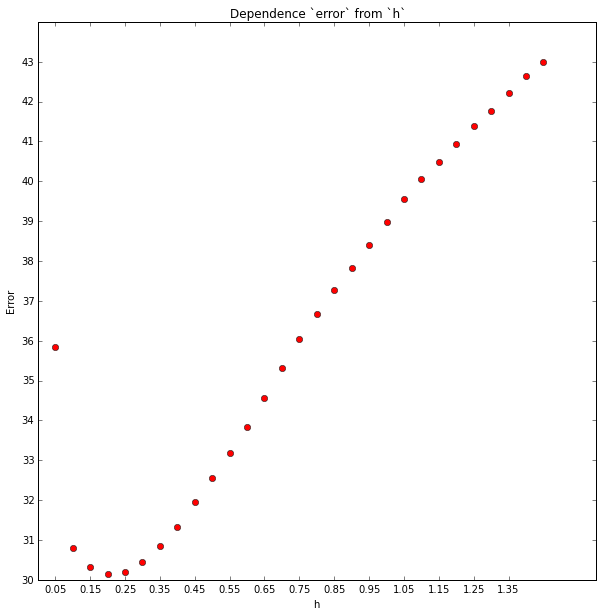

In [18]:
def showError(xs, ys):
    plt.figure(figsize=(10, 10))
    label0, = plt.plot(xs, ys, 'ro')
    plt.xlabel('h')
    plt.ylabel('Error')
    plt.title('Dependence `error` from `h`')
    plt.xticks(np.arange(min(xs), max(xs), 0.1))
    plt.yticks(np.arange(np.floor(min(ys)), np.ceil(max(ys)), 1))
    plt.show()
showError(hs, errors)

In [19]:
regressor.fit(x_scaled, ys, h=0.2)

In [20]:
print("Full dataset train and test")
measure(ys, np.apply_along_axis(regressor.predict, 1, x_scaled))

Full dataset train and test


786.87944661993618

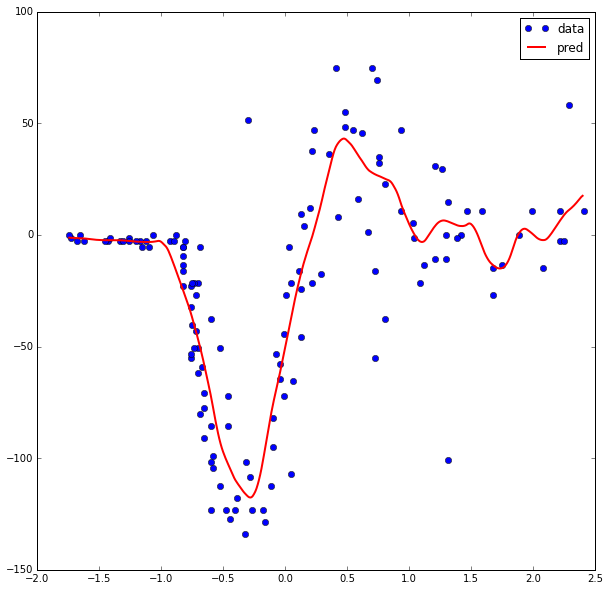

In [21]:
def showDataNPred(xs, ys, lin_x, y_pred):
    plt.figure(figsize=(10, 10))
    label0, = plt.plot(xs, ys, 'bo')
    label1, = plt.plot(lin_x, y_pred, 'r', lw=2)
    plt.legend([label0, label1], ['data', 'pred'])
    plt.show()
x_min, x_max = x_scaled.min(), x_scaled.max()
lin_x = np.resize(np.arange(x_min, x_max, 0.01), (-1, 1))
y_pred = np.apply_along_axis(regressor.predict, 1, lin_x)
showDataNPred(x_scaled, ys, lin_x, y_pred)